# Text-mining-applied-project
Busqueda y Recuperacion de Informacion
Se busca construir un sistema de busqueda y recuperacion de informacion que sea capáz de identificar informacion relavante para el usuario en grandes volumnes de información (Documentos Cientificos). Este proceso se lleva a cabo mediante la construcción de un Bag of Words, metodo utilizado para representar la información de los documentos en palabras.

In [1]:
import glob # libreria para extraer la ruta de los archivos
import re # libreria para manejos de expresiones regulares
import collections #### para poder contar los hash
import pandas as pd # libreria para manejo de bases datos
import numpy as np # libreria para manejo de vectores y arreglos
import json #libreria para leer los metadatos guardados como un json
import operator #Libreria para organizar de mayor a menor
import matplotlib.pyplot as plt #libreria para graficas
from nltk.corpus import stopwords, wordnet # importa las stop words y las palabras del ingles
from nltk.stem.porter import PorterStemmer # metodo para stemming
from nltk.stem.lancaster import LancasterStemmer # metodo para stemming
from nltk.stem import WordNetLemmatizer # metodo para lematizar
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize

### Creación del Bag of Words
Para la creacion del Bag of Words se construye una lista de todos los documentos cientificos almacenados en formato txt, luego se extrae el texto de cada uno de los documentos y se realiza una limpieza para cada una de las palabras en los diferentes documentos. Entre los procesos de limpieza estan:
* Tokenización: Es el proceso de separa un texto en cadenas separadas por espacios o signos de puntuacion.
* Eliminar Stopwords: Eliminar palabras como artículos, conjunciones y preposiciones.
* Stemming: Eliminar los sufijos de la palabra usando PorterStemmer dela libreria NLTK.
* Lemmatization: Proceso de convertir la palabra en la raiz
* Otros: Limpieza de palabras de 1 caracter y palabras con mas de tres letras consecutivas

In [2]:
#Read Files
#files_txt = glob.glob("/opt/datasets/mcda-pi1-20191/papers-txt/*.txt")
files_txt = glob.glob("C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\*") #Computer Andres

# instanciar la clase para lematizar
wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() # instancia una forma de stemming
# llamamos al diccionario de stop words en ingles
sw = stopwords.words("english")

#leer Meta Datos
meta_data = open("xml_parser/metadata_dict.txt","r",encoding='utf-8').read()
meta_data = json.loads(meta_data)

In [3]:
def tokenizer(texto):
    tokens = word_tokenize(texto.lower())
    tokens = [re.sub('[^A-Za-z0-9]+','',word) for word in tokens if not bool(re.search(r'(.)\1{2,}', word))]
    return tokens

def limpiar_tokens(tokens, is_metadata = False):
    if is_metadata:
        return [stemmer.stem(w.lower()) for w in tokens if (len(w)>1) and (w not in sw) and w.isalpha()]       
    else: 
        return [stemmer.stem(w.lower()) for w in tokens if (len(w)>1) and (len(w)<15) and (w not in sw) and w.isalpha() ] 

In [4]:
documentos_text = list()
documentos      = list()
for file in files_txt:
    #Leer Informacion
    input_file = open(file,"r",encoding='utf-8')
    texto = input_file.read()
    meta_data_info = meta_data[file.replace("\\","/").split("/")[-1].replace(".txt","")]
    
    #tokenizacion
    tokens = tokenizer(texto)
    tokens_metada = tokenizer(meta_data_info)
    #mirar cant
    
    # aplica lematizacion, stemming, elimina de stop words y aplica reglas lógicas para reducir la cantidad de tokens
    tokens = limpiar_tokens(tokens)
    tokens_metada = limpiar_tokens(tokens, is_metadata = True)
    documentos_text.append(' '.join(tokens + tokens_metada))
    documentos.append(file)


## Para la creacion del Bag of Words

### Usamos la libreria de machine learning sklearn para construir nuestro diccionario de palabras 

* CountVectorizer: Nos permite contar el numero de palabras que ocurren en cada uno de los documentos tf
* TfidfVectorizer: Calcula el tf  * idf donde idf = $log(\frac{1+n}{1+df})+1$, cada fila del vector esta en norma 2

#### Referencias:
1. [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
2. [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)

In [5]:
count_vectorizer = CountVectorizer(analyzer = "word",tokenizer = word_tokenize,    \
                             preprocessor = None, \
                             stop_words = sw,   \
                             lowercase = True,  \
                             max_features = None)


bow_tf = count_vectorizer.fit_transform(documentos_text)

C:\Users\Andres\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [6]:
bow_tf.shape #doc, words

(980, 90197)

In [7]:
tfidf_vectorizer=TfidfVectorizer(analyzer = "word",tokenizer = word_tokenize,    \
                             preprocessor = None, \
                             stop_words = sw,   \
                             lowercase = True,  \
                             max_features = None)
 
# just send in all your docs here
bow_tfidf = tfidf_vectorizer.fit_transform(documentos_text)

In [8]:
bow_tfidf.shape #doc, words

(980, 90197)

### Convertimos el resultado de CountVectorizer y TfidfVectorizer a un DataFrame de Pandas
Este proceso fue necesario porque estos objetos utilizan las listas nativas de python y se hizo muy ineficiente al momento de construir el inverted index, ya que por ser una lista de listas este tenia que buscar sobre todo el conjunto de datos. Con pandas utilizando la funcion loc, podiamos buscar la palabra o retornando solo el df que necesitabamos haciendo una busqueda dentro de nuestro bag of words.

In [9]:
bow_tfidf_df = pd.DataFrame(bow_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
bow_tfidf_df.head()
#bow_tfidf_df.loc[bow_tfidf_df['aa'] > 0].head()

,aa,aaa,aab,aaba,aabab,aababa,aababaababb,aabb,aabc,aabcdaccaac,...,zzf,zzi,zzmin,zzn,zzpe,zzr,zzth,zzw,zzwp,zzyzx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
bow_tf_df = pd.DataFrame(bow_tf.toarray(), columns=count_vectorizer.get_feature_names())
bow_tf_df.head()
#bow_tf_df.loc[bow_tf_df['aa'] > 0].head()

,aa,aaa,aab,aaba,aabab,aababa,aababaababb,aabb,aabc,aabcdaccaac,...,zzf,zzi,zzmin,zzn,zzpe,zzr,zzth,zzw,zzwp,zzyzx
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Inverted Index
Es la estructura de datos mas utilizada para la busqueda en los sistemas de busqueda y recuperación de información.
Para la construccion de esta estructura de datos utilizamos los diccionarios de python para realizar una indexación por palabra y adicionar una lista de tuplas, donde cada una tiene la informacion del documento, el tfidf de la palabra, el tf y el tamaño en palabras del bag of words para el documento.

##### Ejemplo:

| word        | doc     | tfidf           | tf      | doc_length    |
|-------------|---------|-----------------|---------|---------------|
| biology     | [1,2,7] | [0.01,0.04,0.1] | [3,4,2] | [340,600,428] |
| computer    | [2,3]   | [0.023,0.012]   | [5,18]  | [250,1118]    |
| mathematics | [1]     | [0.1]           | [8]     | [128]         |

In [11]:
documentos_length = [sum(words) for words in bow_tf.toarray()]

In [12]:
inverted_index = {}
for word in bow_tfidf_df.columns:
    inverted_index[word] = []
    for row in bow_tf_df.loc[bow_tf_df[word] > 0].index:
        doc = documentos[row]
        tf = bow_tf_df[word][row]
        tfidf = bow_tfidf_df[word][row]
        doc_length = documentos_length[row]
        inverted_index[word].append( (doc, tfidf, tf, doc_length) )

### Query
Para realizar la busqueda realizamos tres aproximaciones, ya que queriamos ir comparando los resultados poco a poco con el experto que utilizamos metapy, que es una libreria en python utilizada para el procesamiento de texto.

Utilizamos el Okapi BM25 que es una función de ranking que nos permite calificar las busquedas para la Recuperación de información y asignar la relevancia a cada uno de los documentos en un buscador que tiene las palabras que el usuario desea buscar.

$score(D,Q) = \sum_{i=1}^{n}IDF(q_{i}) * \frac{f(q_{i}, D) * (k_{1} + 1)}{f(q_{i}, D) + k_{1} * (1-b+b*\frac{|D|}{avgdl})} $

$k_{1}=1.2, b=0.75$

In [ ]:
def query_inverted_text(term):
    resultado = []
    for doc, freq,_,_ in inverted_index[term]:
        resultado.append(doc)
    return resultado
len(query_inverted_text('biolog'))
#inverted_index['characterist']

In [ ]:
def query_inverted_text(terms=[]):
    resultado = {}
    for term in terms:
        if term in inverted_index:
            for doc, tfidf, tf, doc_length  in inverted_index[term]:
                if doc in resultado:
                    resultado[doc] += tfidf
                else:
                    resultado[doc] = tfidf
    return resultado
query = query_inverted_text(['biolog'])
sorted_x = sorted(query.items(), key=operator.itemgetter(1), reverse=True)[:10]
sorted_x
#inverted_index['characterist']

In [13]:
def query_inverted_text_bm25(query, k1=1.2, b=0.75):
    resultado = {}
    query_tokens = tokenizer(query)
    query_tokens = limpiar_tokens(query_tokens)
    avgdl = np.mean(documentos_length)
    for term in query_tokens:
        doc_query_conriene = len(inverted_index[term])
        query_idf = np.log((len(documentos_length) - doc_query_conriene + 0.5) / (doc_query_conriene + 0.5))
        for doc, tfidf, tf, doc_length  in inverted_index[term]:
            upper = tf *  (k1 + 1)
            below = tf + k1*(1 - b + (b * (doc_length / avgdl)))
            if doc in resultado:
                resultado[doc] += query_idf * (upper / below)
            else:
                resultado[doc] = query_idf * (upper / below)
    return resultado
query = query_inverted_text_bm25("mathematic")
sorted_x = sorted(query.items(), key=operator.itemgetter(1), reverse=True)[:10]
sorted_x

[('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1405.7264.txt',
  -1.0389532952950222),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1310.2728.txt',
  -1.0622960636274603),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1502.04147.txt',
  -1.06293574923681),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1312.0049.txt',
  -1.0796881707128425),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1505.02214.txt',
  -1.0837760906120486),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1311.3158.txt',
  -1.09089817646716),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\0803.2570.txt',
  -1.1155097741190614),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1406.7373.txt',
  -1.1375556107217617),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1504.05895.txt',
  -1.169382830630

In [ ]:
file1 = open("result_query.txt","w") 
file1.writelines('\n'.join([doc for doc, tdfidf in sorted_x]))
file1.close()

In [14]:
import metapy

In [15]:
inv_idx = metapy.index.make_inverted_index("config.toml")

In [16]:
inv_idx.num_docs()

980

In [17]:
ranker = metapy.index.OkapiBM25()

In [36]:
query_meta = metapy.index.Document()
query_meta.content("alejandro")

In [37]:
top_docs = ranker.score(inv_idx, query_meta, num_results=10)

In [38]:
top_docs

[(977, 7.387988567352295),
 (479, 6.242015361785889),
 (625, 5.51742696762085),
 (449, 4.586308479309082),
 (568, 4.551577568054199),
 (664, 4.220107078552246)]

In [39]:
def meta_top_docs(top_docs):
    person = []
    for num, (d_id, d) in enumerate(top_docs):   
        val_1 = inv_idx.label(d_id)
        person.append((val_1, d))
    return person
person = meta_top_docs(top_docs)
person

[('../data/papers_own_impl/1511.09324.txt', 7.387988567352295),
 ('../data/papers_own_impl/1411.3140.txt', 6.242015361785889),
 ('../data/papers_own_impl/1504.01442.txt', 5.51742696762085),
 ('../data/papers_own_impl/1409.7579.txt', 4.586308479309082),
 ('../data/papers_own_impl/1502.02908.txt', 4.551577568054199),
 ('../data/papers_own_impl/1505.03931.txt', 4.220107078552246)]

In [45]:
query2 = query_inverted_text_bm25("alejandro")
sorted_x = sorted(query2.items(), key=operator.itemgetter(1), reverse=True)[:6]
sorted_x

[('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1411.3140.txt',
  7.824607005646157),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1504.01442.txt',
  7.2706848295721676),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1511.09324.txt',
  6.83099113091885),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1502.02908.txt',
  6.539025798542451),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1409.7579.txt',
  6.464701996402047),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1505.06770.txt',
  6.258655590309287)]

In [46]:
#person[0][0].split("/")[-1]
y_true = [i[0].split('/')[-1] for i in person]
y_pred = [j[0].split('\\')[-1] for j in sorted_x]

In [47]:
from sklearn.metrics import confusion_matrix

# matriz de confusion multiclase
confusion_matrix(y_true, y_pred)

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0]], dtype=int64)

In [48]:
y_trueb = [1 if x in y_true else 0 for x in y_true]
print(y_trueb)
print('------------')
y_predb = [1 if x in y_true else 0 for x in y_pred]
print(y_predb)

[1, 1, 1, 1, 1, 1]
------------
[1, 1, 1, 1, 1, 0]


In [49]:
confusion_matrix(y_true=y_trueb, y_pred=y_predb).ravel()

array([0, 0, 1, 5], dtype=int64)

In [50]:
tn, fp, fn, tp = confusion_matrix(y_true=y_trueb, y_pred=y_predb).ravel()
(tn, fp, fn, tp)

(0, 0, 1, 5)

In [56]:
precision

array([1., 1., 1.])

(0.0, 1.0)

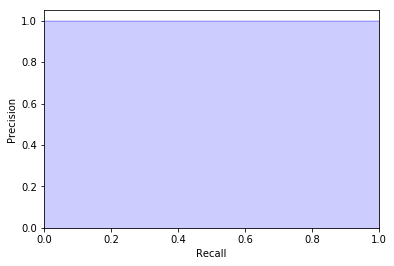

In [53]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_trueb, y_predb)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

In [52]:
p = tp/(tp+fp)
print('Precision ',round(p,2))
print('--------------------')
r = tp/(tp+fn)
print('Recall ',round(r,2))

Precision  1.0
--------------------
Recall  0.83


In [57]:
def calificar_query(querys):
    ranker = metapy.index.OkapiBM25()
    resultado = {}
    for query in querys:
        query_meta = metapy.index.Document()
        query_meta.content(query)
        top_docs = ranker.score(inv_idx, query_meta, num_results=20)
        expert = meta_top_docs(top_docs)
        len_expert = len(expert)
        
        buscador = query_inverted_text_bm25(query)
        buscador = sorted(buscador.items(), key=operator.itemgetter(1), reverse=True)[:len_expert]
        
        #buscador += [0 for i in range(len(expert) - len(buscador))]
        y_true = [i[0].split('/')[-1] for i in expert]
        y_pred = [j[0].split('\\')[-1] for j in buscador]
        #boolean form of y_true and y_pred
        y_trueb = [1 if x in y_true else 0 for x in y_true]
        y_predb = [1 if x in y_true else 0 for x in y_pred]
        
        conf_matrix = confusion_matrix(y_trueb, y_predb).ravel()
        if len(conf_matrix) > 1:
            tn, fp, fn, tp = conf_matrix
        else:
            tn, fp, fn = 0,0,0
            tp = conf_matrix[0]
        p = tp/(tp+fp) #print('Precision ',round(p,2))
        r = tp/(tp+fn) #print('Recall ',round(r,2))
        resultado[query] = (round(p,2), round(r,2))
    return resultado
resultado_compare = calificar_query(["biology", "activity", "machine learning", "hello",
                 "machine", "math", "ascii","magazine", "mahalanobis distance",
                 "kruskal algorithm", "malware", "mathematician", "norm", "matrix norm",
                 "sparse", "sklearn","andres","stochastic", "alejandro", "diego", "liz", "Johan",
                 "fractals", "news", "random forest", "logistic regression", "statistics",
                 "root", "python", "fraud", "inverse matrix", "clustering", "michael jordan", "Carl Friedrich Gauss",
                 "juan diego", "europe", "soccer", "rank","Algebra", "quick sort", "education", "epsilon", "Etymology",
                 "Chinese rice","security","cryptography and network security", "eafit", "bank", "radiology", "haskell",
                 "liverpool", "google", "page ranker", "twitter", "facebook","germany", "colombia", "linux", "text",
                 "text mining", "music", "reggae", "wikipedia", "population", "city", "country", "master and slave",
                 "Polynomial", "Isaac Newton", "ibm", "red hat", "hadoop", "Structured Query Language", 
                 "programming language sql", "software", "Object-oriented programming", "albert einstein", "android",
                 "gpu", "cpu", "keyboard", "hardware", "internet", "intel","aws emr", "magic spell", 
                 "genetic algorithm potatoes", "valuable gem","general electric","world clock","neural networks",
                 "big data", "bytes","tv","business analytics","mental disease", "black market", "integrator project",
                 "simpsons", "likelihood", "text volume", "amazon"])

In [31]:
print(count_vectorizer.get_feature_names())

['aa', 'aaa', 'aab', 'aaba', 'aabab', 'aababa', 'aababaababb', 'aabb', 'aabc', 'aabcdaccaac', 'aaccept', 'aach', 'aachen', 'aaction', 'aad', 'aadm', 'aadom', 'aaecc', 'aaem', 'aag', 'aagaard', 'aagea', 'aai', 'aaia', 'aaihaa', 'aain', 'aaini', 'aaj', 'aalbersberg', 'aalborg', 'aalg', 'aall', 'aalter', 'aaltern', 'aalto', 'aaltofi', 'aam', 'aama', 'aamarkov', 'aamodt', 'aana', 'aanderaa', 'aanstad', 'aanund', 'aapso', 'aar', 'aarabi', 'aardal', 'aarhu', 'aaron', 'aaronson', 'aaroth', 'aarrow', 'aart', 'aarti', 'aas', 'aashtiani', 'aastrategi', 'aat', 'aau', 'aauat', 'aaw', 'aawcondit', 'aaxpi', 'aaz', 'aazhang', 'ab', 'aba', 'abaa', 'abab', 'ababa', 'ababb', 'ababc', 'abac', 'abacaxi', 'abacfromlog', 'abach', 'abad', 'abadi', 'abadirogaway', 'abaioff', 'abaixo', 'abak', 'abalon', 'abandon', 'abaqu', 'abarbanel', 'abarbu', 'abas', 'abat', 'abatzogl', 'abb', 'abba', 'abbaa', 'abbab', 'abbadi', 'abbasi', 'abbasiyadkori', 'abbass', 'abbau', 'abbaur', 'abbb', 'abbeel', 'abbey', 'abbildet', '

In [62]:
querys_result = []
values_result = []
for key, values in resultado_compare.items():
    querys_result.append(key)
    values_result.append(values[1])

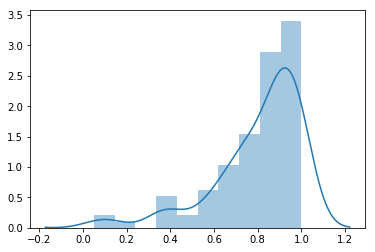

In [63]:
import seaborn as sns

sns.distplot(values_result)

In [35]:
np.percentile(values_result, 10)

0.5550000000000002